In [1]:
# Install yfinance if not already installed
#!pip install yfinance

# Import necessary libraries
import yfinance as yahooFinance
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Disable all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Fetch historical stock data
def get_stock_data(symbol, start_date, end_date):
    stock_data = yahooFinance.download(symbol, start=start_date, end=end_date)
    if stock_data.empty:
        raise ValueError(f'No data found for symbol {symbol} between {start_date} and {end_date}.')
    return stock_data

In [3]:
# Specify stock and date range
stock_symbol = 'NVDA'
stock_start_date = '2024-10-01'
stock_end_date = '2025-02-25'

# Get stock data
stock_data = get_stock_data(stock_symbol, stock_start_date, stock_end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Data Preprocessing

# Handle Missing Data
stock_data = stock_data.ffill()

# Feature engineering
stock_data['Return'] = stock_data['Close'].pct_change()                 # Daily return
stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))  # Log return
stock_data['MA_7'] = stock_data['Close'].rolling(window=7).mean()     # 7-day moving average
stock_data['Volatility'] = stock_data['Close'].rolling(window=10).std() # 10-day volatility

# Drop rows with NaN values
stock_data.dropna(inplace=True)

In [5]:
# Define training and testing date ranges
train_start_date = '2024-10-01'
train_end_date = '2025-02-01'
test_start_date = '2025-02-01'
test_end_date = '2025-02-25'

In [6]:
#Filter date based on date ranges
train_data = stock_data.loc[train_start_date:train_end_date]
test_data = stock_data.loc[test_start_date:test_end_date]

print(f'Training Data: {train_data.index.min()} to {train_data.index.max()}')
print(f'Testing Data: {test_data.index.min()} to {test_data.index.max()}')

Training Data: 2024-10-14 00:00:00 to 2025-01-31 00:00:00
Testing Data: 2025-02-03 00:00:00 to 2025-02-24 00:00:00


In [7]:
# Select features and scale data
features = ['Close', 'Return', 'Log_Return', 'MA_7', 'Volatility']

# Initialize scalers
scaler = MinMaxScaler()

# Scale training data
scaled_train_data = scaler.fit_transform(train_data[features])

# Scale testing data
scaled_test_data = scaler.transform(test_data[features])

In [8]:
# Prepare data for LSTM by creating time steps
def prepare_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i: i + time_step])         # Sequence of time_step days
        y.append(data[i + time_step, 0])         # Target: Close price at time_step+1
    return np.array(X), np.array(y)

In [9]:
time_step = 1 #use the previous day to predict the next day

# Prepare the data
X_train, y_train = prepare_data(scaled_train_data, time_step)
X_test, y_test = prepare_data(scaled_test_data, time_step)

# Extract test dates for plotting
test_dates = test_data.index[time_step:]

In [10]:
# Check shapes for LSTM compatibility
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (74, 1, 5)
y_train shape: (74,)
X_test shape: (14, 1, 5)
y_test shape: (14,)


In [11]:
# Create LSTM Model
model_input_shape = (X_train.shape[1], X_train.shape[2])  # (time_steps, num_features)

model = Sequential()

# First LSTM layer with 100 units and return sequences for stacking another LSTM
model.add(LSTM(units=100, return_sequences=True, input_shape=model_input_shape))
model.add(Dropout(rate=0.3))  # Dropout to reduce overfitting

# Second LSTM layer with 50 units
model.add(LSTM(units=50))
model.add(Dropout(rate=0.3))

# Dense layer to produce the final output (predicted Close price)
model.add(Dense(units=1))

# Compile the model with Adam optimizer and Mean Squared Error loss
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the LSTM Model
epochs = 100
batch_size = 5

# Train the model on training data and validate on test data
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4123
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2161 
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0656 
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0471 
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0434 
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0332 
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0275 
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 
Epoch 13/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 
Epoch 14/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 
Epoch 15/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

In [13]:
# Predict Log_Return on the test data
predictions = model.predict(X_test)

# Inverse scaling to get actual price values for comparison
scaled_y_test = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), scaler.n_features_in_ - 1))], axis=1))[:, 0]

scaled_predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), scaler.n_features_in_ - 1))], axis=1))[:, 0]

test_dates = test_dates[:len(scaled_predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [14]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(scaled_y_test, scaled_predictions))
print(f'Test RMSE: {rmse:.2f}')

Test RMSE: 3.32


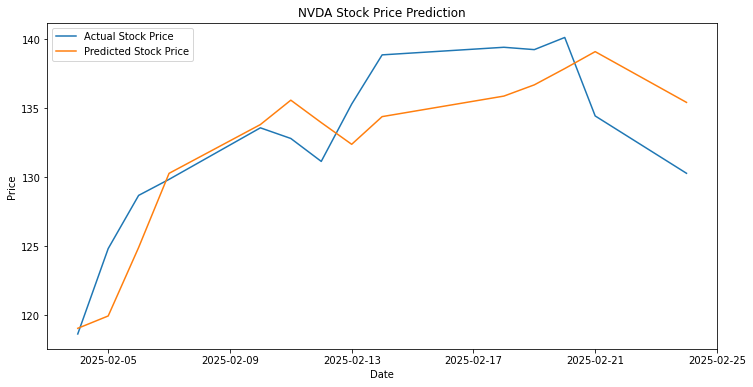

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_dates, scaled_y_test, label='Actual Stock Price')
plt.plot(test_dates, scaled_predictions, label='Predicted Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()